In [1]:
import pandas as pd
from neo4j import GraphDatabase
from copy import deepcopy
import matplotlib.pyplot as plt

In [2]:
import os 
os.chdir('..')

In [3]:
driver = GraphDatabase.driver(uri="bolt://localhost:7687", auth=('neo4j', 'neo4j'))

In [4]:
with driver.session(database="ret") as session:
    artworks_time = pd.DataFrame(session.run("MATCH (a:Artwork) where a.date is not null return a.name as artwork, a.date as date ").data())
artworks_time

,artwork,date
0,giuseppe-arcimboldo_portrait-of-eve-1578.jpg,1578
1,giuseppe-arcimboldo_portrait-of-adam-1578.jpg,1578
2,giuseppe-arcimboldo_the-vegetable-bowl.jpg,c.1590
3,giuseppe-arcimboldo_vertumnus-emperor-rudolph-...,1591
4,giuseppe-arcimboldo_the-dinner.jpg,1570
...,...,...
89767,ismail-shammout_self-portrait-1955.jpg,1955
89768,ismail-shammout_nahnou-bi-kheyr-taminouna-we-a...,1976
89769,ismail-shammout_odyssey-of-a-people-detail-198...,1981
89770,ismail-shammout_untitled-from-the-tall-al-zaat...,1976


In [5]:
artworks_time["isdate"] = artworks_time["date"].map(lambda x: x.isdigit())
artworks_time

,artwork,date,isdate
0,giuseppe-arcimboldo_portrait-of-eve-1578.jpg,1578,True
1,giuseppe-arcimboldo_portrait-of-adam-1578.jpg,1578,True
2,giuseppe-arcimboldo_the-vegetable-bowl.jpg,c.1590,False
3,giuseppe-arcimboldo_vertumnus-emperor-rudolph-...,1591,True
4,giuseppe-arcimboldo_the-dinner.jpg,1570,True
...,...,...,...
89767,ismail-shammout_self-portrait-1955.jpg,1955,True
89768,ismail-shammout_nahnou-bi-kheyr-taminouna-we-a...,1976,True
89769,ismail-shammout_odyssey-of-a-people-detail-198...,1981,True
89770,ismail-shammout_untitled-from-the-tall-al-zaat...,1976,True


In [6]:
artworks_time[~artworks_time["isdate"]]

,artwork,date,isdate
2,giuseppe-arcimboldo_the-vegetable-bowl.jpg,c.1590,False
32,frida-kahlo_portrait-of-frida-s-family-1954.jpg,1950 - 1954,False
44,frida-kahlo_self-portrait-as-a-tehuana-1943.jpg,1940 - 1943,False
91,giorgione_moses-undergoing-trial-by-fire-1505.jpg,1502 - 1505,False
93,giorgione_the-sleeping-venus-1510.jpg,1508 - 1510,False
...,...,...,...
89731,lois-mailou-jones_greetings-1948.jpg,c.1948,False
89734,beauford-delaney_composition-16-1956.jpg,1954 - 1956,False
89741,beauford-delaney_abstraction-1961.jpg,c.1961,False
89756,beauford-delaney_untitled-new-york-city-1945.jpg,c.1945,False


By now two cases:
* c.`date`
* `start` - `end`

In [7]:
def clean_date(raw):
    if raw['date'].isdigit():
        return int(raw["date"])
    if raw["date"].startswith('c.'):
        raw['date'] = raw["date"][2:]
        return clean_date(raw)
    if ' - ' in raw["date"]:
        raw['date'] = raw["date"].split(' - ')[1]
        return clean_date(raw)
    if ' ; ' in raw["date"]:
        raw['date'] = raw["date"].split(' ; ')[0]
        return clean_date(raw)
    raise Exception(f"cannot cast {raw['date']}")

In [8]:
artworks_time["date"] =  artworks_time.apply(clean_date, axis=1)
artworks_time

,artwork,date,isdate
0,giuseppe-arcimboldo_portrait-of-eve-1578.jpg,1578,True
1,giuseppe-arcimboldo_portrait-of-adam-1578.jpg,1578,True
2,giuseppe-arcimboldo_the-vegetable-bowl.jpg,1590,False
3,giuseppe-arcimboldo_vertumnus-emperor-rudolph-...,1591,True
4,giuseppe-arcimboldo_the-dinner.jpg,1570,True
...,...,...,...
89767,ismail-shammout_self-portrait-1955.jpg,1955,True
89768,ismail-shammout_nahnou-bi-kheyr-taminouna-we-a...,1976,True
89769,ismail-shammout_odyssey-of-a-people-detail-198...,1981,True
89770,ismail-shammout_untitled-from-the-tall-al-zaat...,1976,True


<Axes: xlabel='date'>

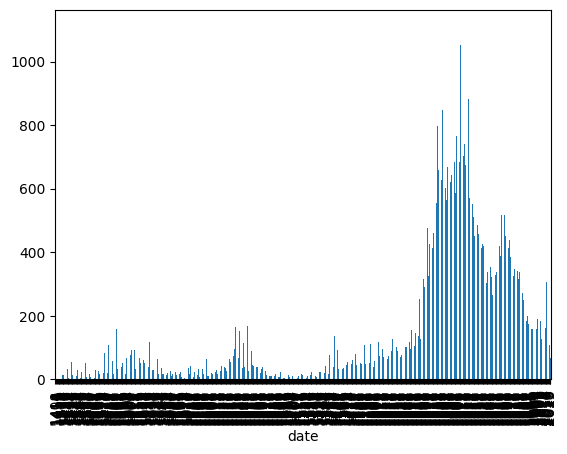

In [9]:
artworks_time["date"].value_counts().sort_index().plot(kind='bar')

In [10]:
artworks_time['century'] = (artworks_time['date'] // 100) * 100
artworks_time

,artwork,date,isdate,century
0,giuseppe-arcimboldo_portrait-of-eve-1578.jpg,1578,True,1500
1,giuseppe-arcimboldo_portrait-of-adam-1578.jpg,1578,True,1500
2,giuseppe-arcimboldo_the-vegetable-bowl.jpg,1590,False,1500
3,giuseppe-arcimboldo_vertumnus-emperor-rudolph-...,1591,True,1500
4,giuseppe-arcimboldo_the-dinner.jpg,1570,True,1500
...,...,...,...,...
89767,ismail-shammout_self-portrait-1955.jpg,1955,True,1900
89768,ismail-shammout_nahnou-bi-kheyr-taminouna-we-a...,1976,True,1900
89769,ismail-shammout_odyssey-of-a-people-detail-198...,1981,True,1900
89770,ismail-shammout_untitled-from-the-tall-al-zaat...,1976,True,1900


Text(0.5, 1.0, 'Time distribution')

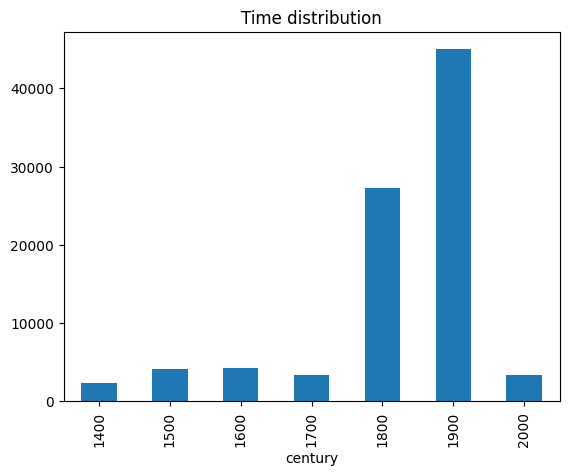

In [11]:
artworks_time['century'].value_counts().sort_index().plot(kind='bar')
plt.title("Time distribution")

In [12]:
len(artworks_time)

89772

In [13]:
with driver.session(database="ret") as session:
    artworks_time_style = pd.DataFrame(session.run("MATCH (a:Artwork)--(s:Style) where a.date is not null return a.name as artwork, a.date as date, s.name as style ").data())
artworks_time_style

,artwork,date,style
0,zinaida-serebriakova_menton-beach-with-umbrell...,1931,art deco
1,zinaida-serebriakova_bath-1926.jpg,1926,art deco
2,john-vassos_illustration-for-oscar-wilde-s-sal...,1927 ; United States,art deco
3,stanislaw-szukalski_flower-of-dreams-1917.jpg,1917,art deco
4,erte_prisoner-of-love-1983.jpg,1983,art deco
...,...,...,...
89767,theodor-severin-kittelsen_askeladdens-eventyr-...,1900,neo-romanticism
89768,stanley-spencer_bellrope-meadow-1936.jpg,1936,neo-romanticism
89769,theodor-severin-kittelsen_noekken-1904-1.jpg,1904,neo-romanticism
89770,stanley-spencer_sorting-laundry-1927.jpg,1927,neo-romanticism


Text(0.5, 1.0, 'Style distribution for date-catalogued artworks')

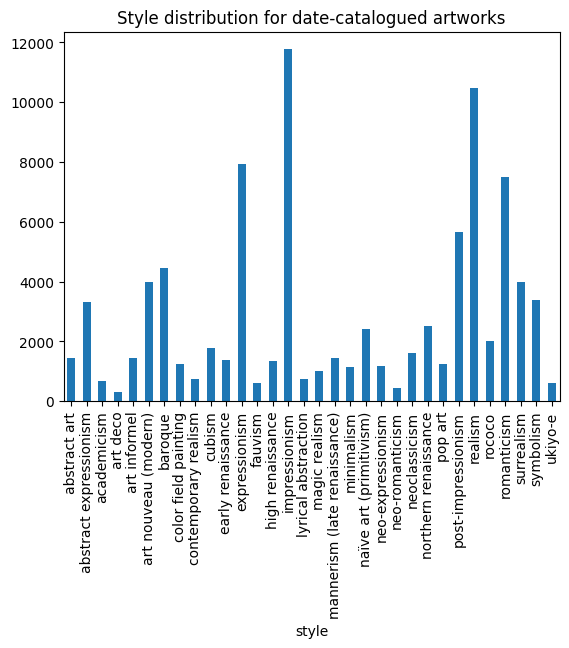

In [14]:
artworks_time_style["style"].value_counts().sort_index().plot(kind='bar')
plt.title("Style distribution for date-catalogued artworks")

In [15]:
len(artworks_time_style["style"].unique())

32

In [16]:
with driver.session(database="ret") as session:
    artworks_style = pd.DataFrame(session.run("MATCH (a:Artwork)--(s:Style) return a.name as artwork, s.name as style ").data())
artworks_style

,artwork,style
0,zinaida-serebriakova_menton-beach-with-umbrell...,art deco
1,erte_autumn-song.jpg,art deco
2,erte_feathers.jpg,art deco
3,john-austen_hamlet-6.jpg,art deco
4,zinaida-serebriakova_bath-1926.jpg,art deco
...,...,...
116470,theodor-severin-kittelsen_noekken-1904-1.jpg,neo-romanticism
116471,theodor-severin-kittelsen_kveld-paa-soletunet-...,neo-romanticism
116472,theodor-severin-kittelsen_brudeferden-i-hardan...,neo-romanticism
116473,stanley-spencer_sorting-laundry-1927.jpg,neo-romanticism


Text(0.5, 1.0, 'Style distribution for all artworks')

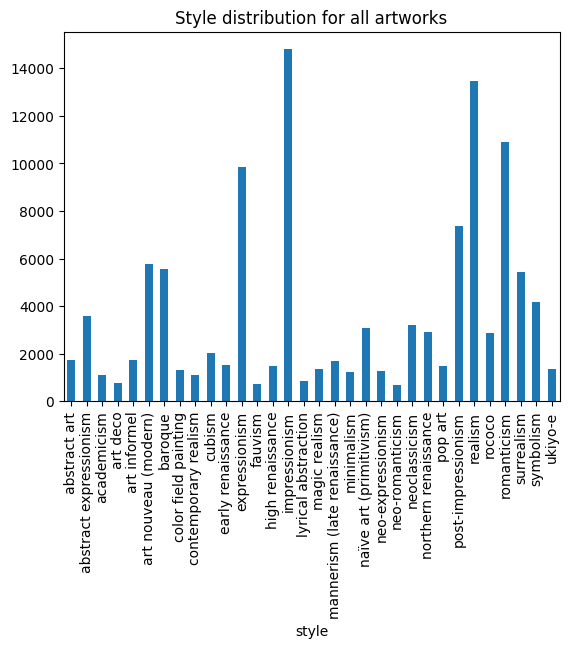

In [17]:
artworks_style["style"].value_counts().sort_index().plot(kind='bar')
plt.title("Style distribution for all artworks")

<Axes: xlabel='style'>

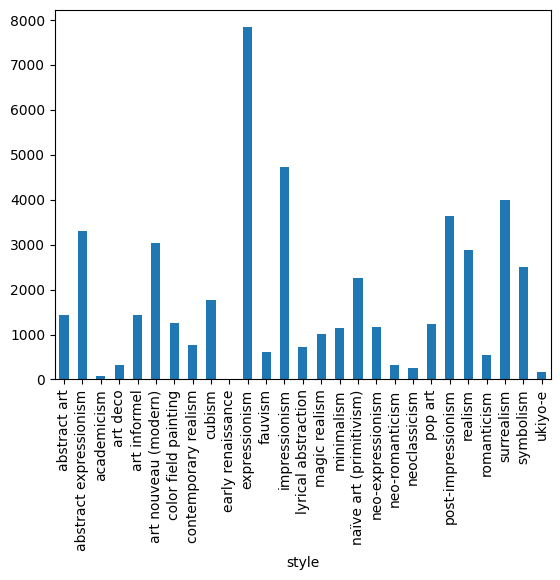

In [18]:
artworks_time_style["date"] =  artworks_time_style.apply(clean_date, axis=1)
artworks_time_style['century'] = (artworks_time_style['date'] // 100) * 100
modern_artwork_style = artworks_time_style[artworks_time_style["century"] >= 1900]
modern_artwork_style["style"].value_counts().sort_index().plot(kind='bar')

In [20]:
len(modern_artwork_style["style"].unique())

27

<Axes: xlabel='style'>

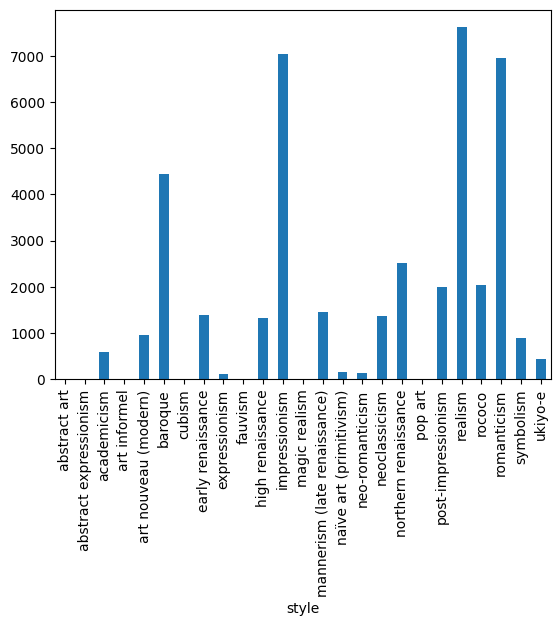

In [21]:
old_artwork_style = artworks_time_style[artworks_time_style["century"] < 1900]
old_artwork_style["style"].value_counts().sort_index().plot(kind='bar')

In [22]:
len(old_artwork_style["style"].unique())

25

In [27]:
common = set(old_artwork_style["style"].unique()) & set(modern_artwork_style["style"].unique())
common

{'abstract art',
 'abstract expressionism',
 'academicism',
 'art informel',
 'art nouveau (modern)',
 'cubism',
 'early renaissance',
 'expressionism',
 'fauvism',
 'impressionism',
 'magic realism',
 'naïve art (primitivism)',
 'neo-romanticism',
 'neoclassicism',
 'pop art',
 'post-impressionism',
 'realism',
 'romanticism',
 'symbolism',
 'ukiyo-e'}

In [28]:
len(common)

20